#**Testes Estatísticos usando Python**

Para realizarmos testes estatísticos com python a pricipal biblioteca existente é a **SciPy** ( acesse a documentação [aqui](https://docs.scipy.org/doc/scipy/reference/stats.html)).

Como vimos nos materiais disponibilizados, as possibilidades de testes são muitas. Aqui nesse tutorial, a ideia é passar por dois dos testes mais utilizados um para testar a normalidade dos dados e outro teste para dados normais não pareadas.

Para verificar as funções para realizar os demais testes usando a biblioteca SciPy, sugiro acessar [esse material](https://tmfilho.github.io/pyestbook/math/03_scip.html#testes-de-hipotese) ou a própria documentação da biblioteca.


## **Importanto os dados**

Para esse tutorial vamos usar uma base adaptada de restaurantes de São Paulo cadastrados em uma empresa FoodTech - dados foram descaracterizados. Nessa base temos o identificator do restaurante, a categoria (os restaurantes estão dividido em categoria A e B) e o número de pedidos de um mês. As categorias siginificam diferentes planos de cadastro que os restaurantes tem acesso ao fecharem contrato com a empresa.

Baixe a base de dados em CSV [aqui](https://docs.google.com/spreadsheets/d/1FIwfQJpePLXfpYTCt6GtlPFdN-l0fmfmXASYOxof7vg/edit#gid=1901110975).

In [2]:
#importando a biblioteca pandas
import pandas as pd

#Importando o dataset
dataset = pd.read_csv('dados_testes_estatisticos.csv')
dataset.head()

,restaurante,categoria,pedidos
0,1,CAT_A,564
1,2,CAT_A,3656
2,3,CAT_B,741
3,4,CAT_A,869
4,5,CAT_A,117


## **Mas o que queremos saber sobre esses restaurantes e essas categorias?**

A princípio, queremos saber se os restaurantes de diferentes categorias possuem diferença na distribuição de pedidos.

Mas precisamos fazer um teste para isso? Vamos verificar...

**Qual a média de pedidos entre categoria A e categoria B?**

In [3]:
#calculo da média
dataset.groupby(['categoria']).agg({'pedidos': ['mean']})

,pedidos
,mean
categoria,
CAT_A,943.253739
CAT_B,535.115832


Pela média, parece que tem diferença sim, mas a média é só um número...

É melhor conferirmos a distribuição dos pedidos.

**Qual a distribuição de pedidos entre as categorias?**

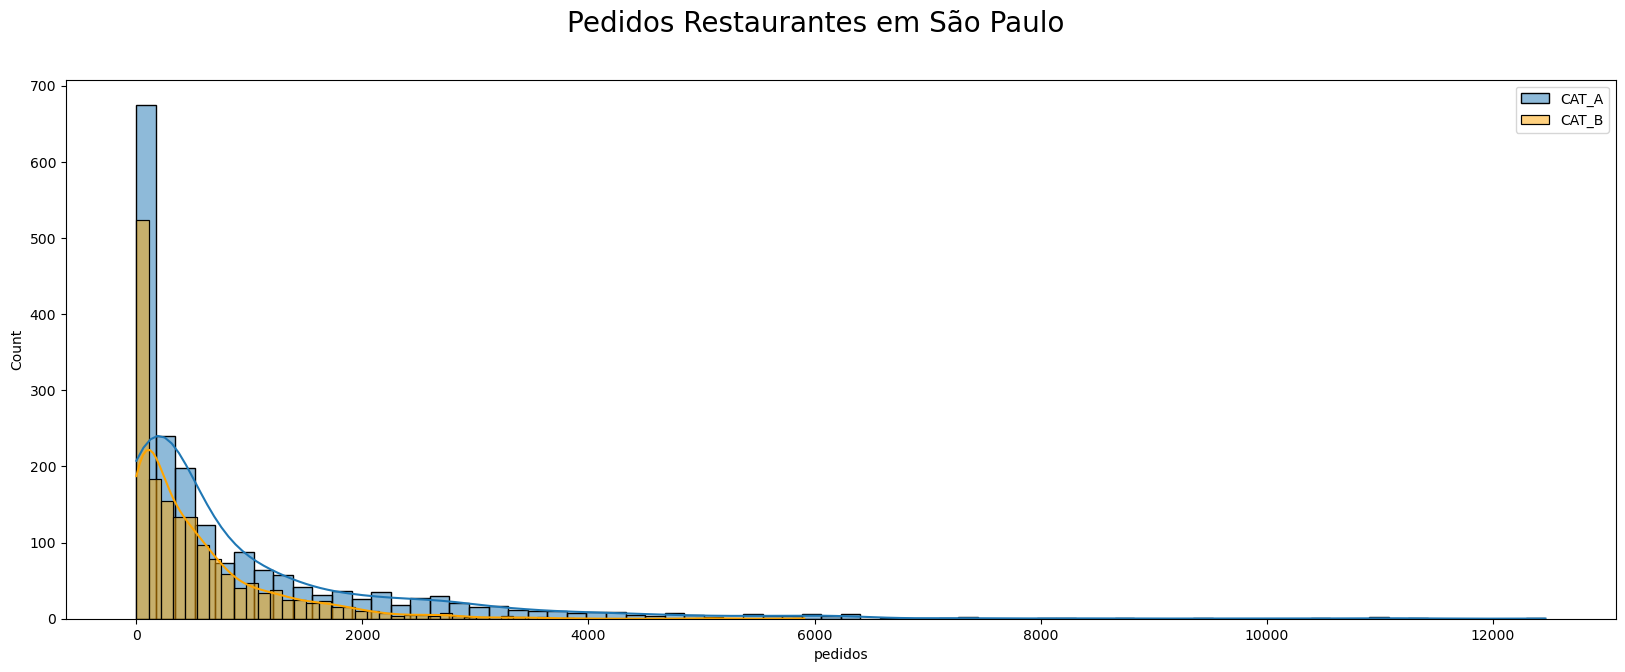

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 7))
fig.suptitle('Pedidos Restaurantes em São Paulo', fontsize=20)

sns.histplot(dataset[dataset['categoria'] == 'CAT_A']['pedidos'], ax=ax, label="CAT_A", kde=True)
sns.histplot(dataset[dataset['categoria'] == 'CAT_B']['pedidos'], ax=ax, label="CAT_B", kde=True, color='orange')
ax.legend()

plt.show()

### **Com esse gráfico, a dúvida fica... será que as distribuições realmente possuem diferença em médias? :thinking...**

## **Os dados seguem uma distribuição Normal?**

Bom, se vamos ter que fazer o teste para verificar se de fato é possível afirmar que a distribuição de pedidos é diferente (ou igual), antes temos que saber se nossos dados seguem uma distribuição normal, pois isso influencia no teste a ser feito, lembram?

In [6]:
import numpy as np
from scipy import stats

In [10]:
from sqlalchemy.sql.expression import true
#inicializa três listas vazias.
#cat_a_means_list armazenará as médias da categoria A, cat_b_means_list armazenará as médias da categoria B e diffs armazenará as diferenças entre as médias dos dois grupos.
cat_a_means_list, cat_b_means_list, diffs = [], [], []

for _ in range(1000):   #Esta linha inicia um loop que será executado 1000 vezes. Cada iteração representa uma amostra de bootstrap.

    #Esta linha cria uma amostra de bootstrap a partir do conjunto de dados dataset. withReplacement=True significa que o mesmo ponto de dados pode ser amostrado mais de uma vez, e fraction=1.0 significa que o tamanho da amostra é o mesmo que o tamanho original do conjunto de dados.
    bootsamp = dataset.sample(replace=True, frac=1.0)

    #Estas linhas calculam a média da coluna pedidos para a categoria
    cat_a_sample = bootsamp[bootsamp['categoria'] == 'CAT_A']['pedidos'].mean()
    cat_b_sample = bootsamp[bootsamp['categoria'] == 'CAT_B']['pedidos'].mean()    

    #Estas linhas adicionam a média calculada da categoria às listas
    cat_a_means_list.append(cat_a_sample)
    cat_b_means_list.append(cat_b_sample)
    
    #Esta linha calcula a diferença entre as médias e adiciona à lista
    diffs.append(cat_b_sample - cat_a_sample)

    '''#Esta linha imprime o número atual da iteração a cada 200 iterações.
    for i in range(0, 1000, 200):
      print(i)'''

**Verificando a distribuição amostral**

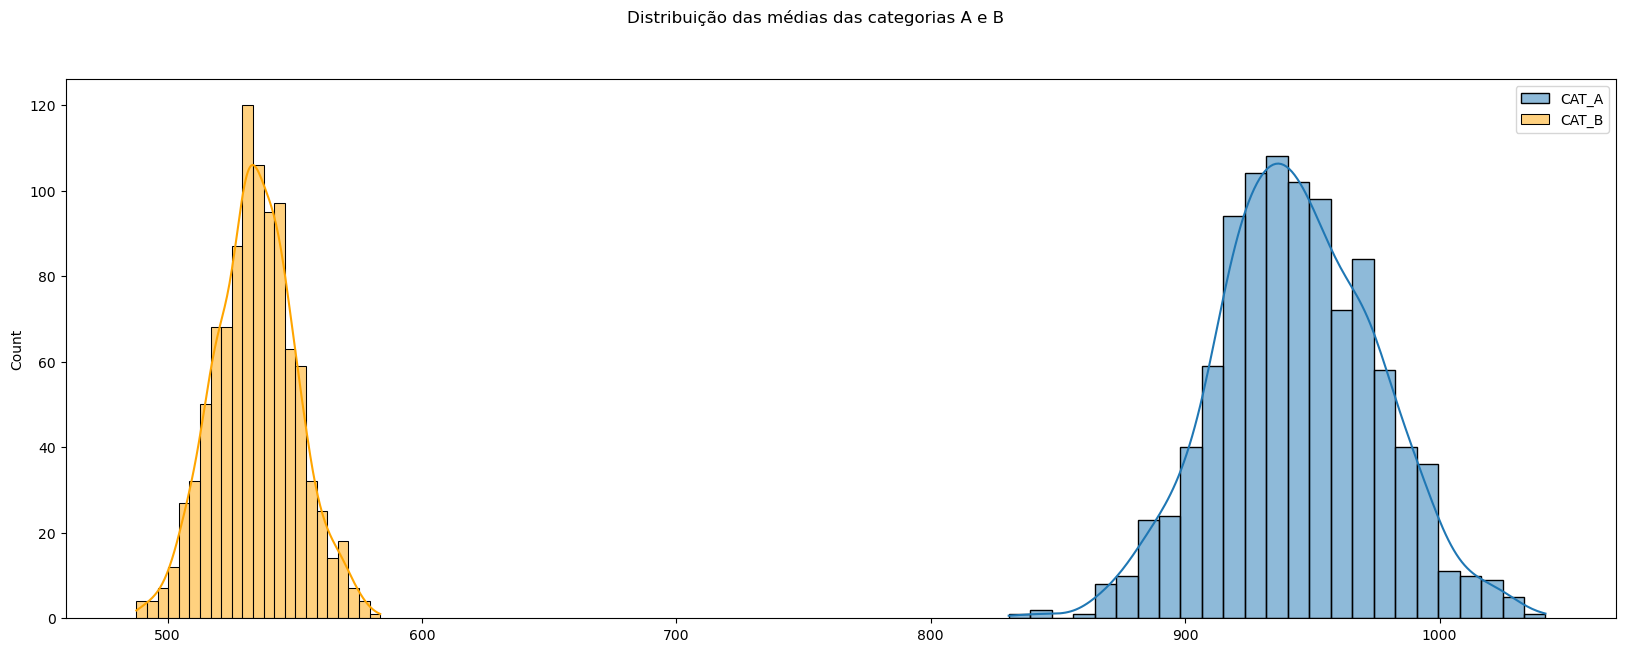

In [12]:
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle('Distribuição das médias das categorias A e B')

sns.histplot(cat_a_means_list, ax=ax, label="CAT_A", kde=True)
sns.histplot(cat_b_means_list, ax=ax, label="CAT_B", kde=True, color='orange')
ax.legend()

plt.show()

**Aplicando o teste de Kolgomorov Smirnov**

Referencia:
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

 two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

In [15]:
# Aplicando o teste de Kolmogorov-Smirnov para a categoria A
ksResult_CatA = stats.kstest(cat_a_means_list, 'norm', args=stats.norm.fit(cat_a_means_list))

print('Categoria A')
print('p-valor = ', ksResult_CatA.pvalue)
if ksResult_CatA.pvalue < 0.05:
    print('Indicativo que a distribuição não tem aderência à normalidade - Rejeitar H0')
else:
    print('Indicativo que a distribuição tem aderência à normalidade - Aceitar H0')

print('')
# Aplicando o teste de Kolmogorov-Smirnov para a categoria B
ksResult_CatB = stats.kstest(cat_b_means_list, 'norm', args=stats.norm.fit(cat_b_means_list))

print('Categoria B')
print('p-valor = ', ksResult_CatB.pvalue)
if ksResult_CatB.pvalue < 0.05:
    print('Indicativo que a distribuição não tem aderência à normalidade - Rejeitar H0')
else:
    print('Indicativo que a distribuição tem aderência à normalidade - Aceitar H0')

Categoria A
p-valor =  0.5973861922357013
Indicativo que a distribuição tem aderência à normalidade - Aceitar H0

Categoria B
p-valor =  0.8225875926330714
Indicativo que a distribuição tem aderência à normalidade - Aceitar H0


## **Aplicando o Teste Estatístico**

Temos que aplicar o teste para dados quantitativos que segue uma distribuição normal e sabendo que vamos comparar dois grupo não pareados (independentes).

Com isso temos que aplicar o teste t não pareado.

**Definição das hipóteses:**

H0: u1 = u2 -> u1 - u2 = 0 (médias iguais)

H1: u1 != u2 -> u1 - u2 != 0 (médias diferentes)

In [16]:
cat_a_list = dataset[dataset['categoria'] == 'CAT_A']['pedidos'].tolist()
cat_b_list = dataset[dataset['categoria'] == 'CAT_B']['pedidos'].tolist()

t_results = stats.ttest_ind(cat_b_list, cat_a_list, equal_var=False)

print('Estatística t = ', t_results[0])
print('p-valor = ', t_results[1])

if t_results[1] < 0.05:
    print('Rejeitar H0')
else:
    print('Aceitar H0')

Estatística t =  -11.652552022982299
p-valor =  1.1135597416416567e-30
Rejeitar H0
